In [4]:
# Setting up a custom stylesheet in IJulia
from IPython.core.display import HTML
from IPython import utils  
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())
#HTML("""
#<style>
#open('style.css','r').read()
#</style>
#""")

In [5]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym
sym.init_printing() 
import solowpy

# 4. Solving the model

## 4.1 Solow model as an initial value problem

The Solow model with can be formulated as an initial value problem (IVP) as follows.

$$ \dot{k}(t) = sf(k(t)) - (g + n + \delta)k(t),\ t\ge t_0,\ k(t_0) = k_0 \tag{4.1.0} $$

The solution to this IVP is a function $k(t)$ describing the time-path of capital stock (per unit effective labor). Our objective in this section will be to explore methods for approximating the function $k(t)$. The methods we will learn are completely general and can be used to solve any IVP. Those interested in learning more about these methods should start by reading Chapter 10 of [*Numerical Methods for Economists*](http://mitpress.mit.edu/books/numerical-methods-economics) by Ken Judd before proceeding to John Butcher's excellent book entitled [*Numerical Methods for solving Ordinary Differential Equations*](http://www.shivanian.com/teaching%20avtivities/Butcher.pdf).

Before discussing numerical methods we should stop and consider whether or not there are any special cases (i.e., combintions of parameters) for which the the initial value problem defined in 4.2.1 might have an analytic solution. Analytic results can be very useful in building intuition about the economic mechanisms at play in a model and are invaluable for debugging code.

## 4.2 Analytic methods

### 4.2.1 Analytic solution for a model with Cobb-Douglas production

The Solow model with Cobb-Douglas production happens to have a completely [general analytic solution](https://github.com/davidrpugh/numerical-methods/raw/master/labs/lab-1/solow-analytic-solution.pdf):

$$ k(t) = \left[\left(\frac{s}{n+g+\delta}\right)\left(1 -  e^{-(n + g + \delta) (1-\alpha) t}\right) + k_0^{1-\alpha}e^{-(n + g + \delta) (1-\alpha) t}\right]^{\frac{1}{1-\alpha}} \tag{4.2.0}$$

This analytic result is available via the `analytic_solution` method of the `solow.CobbDouglasModel` class.

In [25]:
solowpy.CobbDouglasModel.analytic_solution?

In [29]:
solowpy.CobbDouglasModel.steady_state?

### Example: Computing the analytic trajectory
We can compute an analytic solution for our Solow model like so...

In [21]:
# define model parameters
cobb_douglas_params = {'A0': 1.0, 'L0': 1.0, 'g': 0.02, 'n': 0.03, 's': 0.15,
                      'delta': 0.05, 'alpha': 0.33}

# create an instance of the solow.Model class
cobb_douglas_model = solowpy.CobbDouglasModel(params=cobb_douglas_params)

In [13]:
cobb_douglas_model.steady_state

1.8315668508047822

In [14]:
# specify some initial condition
k0 = 0.5 * cobb_douglas_model.steady_state

# grid of t values for which we want the value of k(t)
ti = np.linspace(0, 100, 10)

# generate a trajectory!
cobb_douglas_model.analytic_solution(ti, k0)

array([[   0.        ,    0.91578343],
       [  11.11111111,    1.37081903],
       [  22.22222222,    1.60723533],
       [  33.33333333,    1.72380474],
       [  44.44444444,    1.78011125],
       [  55.55555556,    1.80706521],
       [  66.66666667,    1.81991504],
       [  77.77777778,    1.8260292 ],
       [  88.88888889,    1.82893579],
       [ 100.        ,    1.83031695]])

...and we can make a plot of this solution like so...

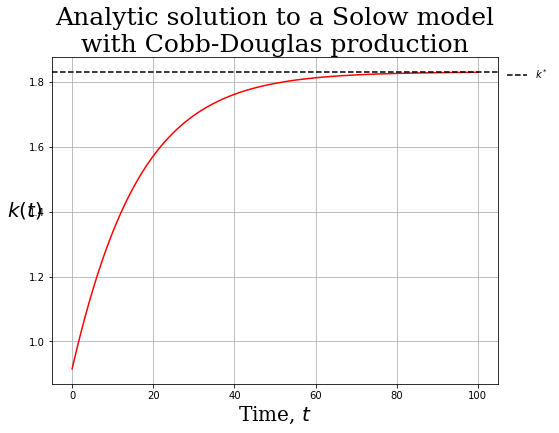

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# compute the solution
ti = np.linspace(0, 100, 1000)
analytic_traj = cobb_douglas_model.analytic_solution(ti, k0)

# plot this trajectory
ax.plot(ti, analytic_traj[:,1], 'r-')

# equilibrium value of capital stock (per unit effective labor)
ax.axhline(cobb_douglas_model.steady_state, linestyle='dashed',
           color='k', label='$k^*$')

# axes, labels, title, etc
ax.set_xlabel('Time, $t$', fontsize=20, family='serif')
ax.set_ylabel('$k(t)$', rotation='horizontal', fontsize=20, family='serif')
ax.set_title('Analytic solution to a Solow model\nwith Cobb-Douglas production',
             fontsize=25, family='serif')
ax.legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
ax.grid('on')

plt.show()

### 4.2.2 Linearized solution to general model

In general there will not be closed-form solutions for the Solow model. The standard approach to obtaining general analytical results for the Solow model is to linearize the equation of motion for capital stock (per unit effective labor). Linearizing the equation of motion of capital (per unit effective labor) amounts to taking a first-order [Taylor approximation](http://en.wikipedia.org/wiki/Taylor_series) of equation 4.1.0 around its long-run equilibrium $k^*$:

$$ \dot{k}(t) \approx -\lambda (k(t) - k^*),\ t \ge t_0,\ k(t_0)=k_0 \tag{4.2.1}$$

where the *speed of convergence*, $\lambda$, is defined as 

$$ \lambda = -\frac{\partial \dot{k}(k(t))}{\partial k(t)}\bigg|_{k(t)=k^*} \tag{4.2.2} $$

The solution the the linear differential equation 4.2.1 is

$$ k(t) = k^* + e^{-\lambda t}(k_0 - k^*). \tag{4.2.3} $$

To complete the solution it remains to find an expression for the speed of convergence $\lambda$:

\begin{align}
    \lambda \equiv -\frac{\partial \dot{k}(k(t))}{\partial k(t)}\bigg|_{k(t)=k^*} =& -[sf'(k^*) - (g + n+ \delta)] \\
    =& (g + n+ \delta) - sf'(k^*) \\
    =& (g + n + \delta) - (g + n + \delta)\frac{k^*f'(k^*)}{f(k^*)} \\
    =& (1 - \alpha_K(k^*))(g + n + \delta) \tag{4.2.4}
\end{align}
where the elasticity of output with respect to capital, $\alpha_K(k)$, is

$$\alpha_K(k) = \frac{k^*f'(k^*)}{f(k^*)}. \tag{4.2.5}$$

### Example: Computing the linearized trajectory
One can compute a linear approximation of the model solution using the `linearized_solution` method of the `solow.Model` class as follows.

In [7]:
# specify some initial condition
k0 = 0.5 * cobb_douglas_model.steady_state

# grid of t values for which we want the value of k(t)
ti = np.linspace(0, 100, 10)

# generate a trajectory!
cobb_douglas_model.linearized_solution(ti, k0)

array([[   0.        ,    0.91578343],
       [  11.11111111,    1.39657145],
       [  22.22222222,    1.62494486],
       [  33.33333333,    1.73342179],
       [  44.44444444,    1.78494813],
       [  55.55555556,    1.80942305],
       [  66.66666667,    1.82104859],
       [  77.77777778,    1.82657069],
       [  88.88888889,    1.82919369],
       [ 100.        ,    1.8304396 ]])

### 4.2.3 Accuracy of the linear approximation

In [24]:
# initial condition
t0, k0 = 0.0, 0.5 * cobb_douglas_model.steady_state

# grid of t values for which we want the value of k(t)
ti = np.linspace(t0, 100, 1000)

# generate the trajectories
analytic = cobb_douglas_model.analytic_solution(ti, k0)
linearized = cobb_douglas_model.linearized_solution(ti, k0)

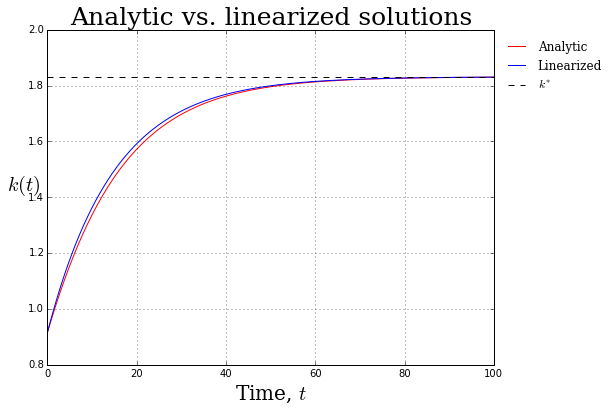

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(ti, analytic[:,1], 'r-', label='Analytic')
ax.plot(ti, linearized[:,1], 'b-', label='Linearized')

# demarcate k*
ax.axhline(cobb_douglas_model.steady_state, linestyle='dashed', 
            color='k', label='$k^*$')

# axes, labels, title, etc
ax.set_xlabel('Time, $t$', fontsize=20, family='serif')
ax.set_ylabel('$k(t)$', rotation='horizontal', fontsize=20, family='serif')
ax.set_title('Analytic vs. linearized solutions', fontsize=25, family='serif')
ax.legend(loc='best', frameon=False, prop={'family':'serif'},
          bbox_to_anchor=(1.0, 1.0))
ax.grid('on')

fig.show()

## 4.3 Finite-difference methods

Four of the best, most widely used ODE integrators have been implemented in the `scipy.integrate` module (they are called `dopri5`, `dop85`, `lsoda`, and `vode`). Each of these integrators uses some type of adaptive step-size control: the integrator adaptively adjusts the step size $h$ in order to keep the approximation error below some user-specified threshold). The cells below contain code which compares the approximation error of the forward Euler with those of [`lsoda`](http://computation.llnl.gov/casc/nsde/pubs/u113855.pdf) and [`vode`](http://jeffreydk.site50.net/papers/BDFmethodpaper.pdf). Instead of simple linear interpolation (i.e., `k=`1), I set `k=5` for 5th order [B-spline](http://en.wikipedia.org/wiki/B-spline) interpolation.

...finally, we can plot trajectories for different initial conditions. Note that the analytic solutions converge to the long-run equilibrium no matter the initial condition of capital stock (per unit of effective labor) providing a nice graphical demonstration that the Solow model is globally stable.

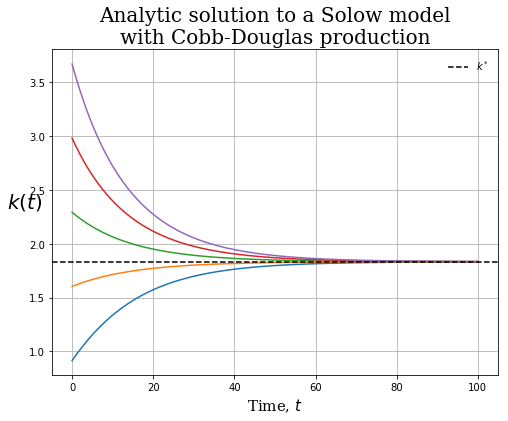

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# lower and upper bounds for initial conditions
k_star = cobb_douglas_model.steady_state
k_l = 0.5 * k_star
k_u = 2.0 * k_star

for k0 in np.linspace(k_l, k_u, 5):

    # compute the solution
    ti = np.linspace(0, 100, 1000)
    analytic_traj = solowpy.CobbDouglasModel.analytic_solution(cobb_douglas_model, ti, k0)
    
    # plot this trajectory
    ax.plot(ti, analytic_traj[:,1])

# equilibrium value of capital stock (per unit effective labor)
ax.axhline(k_star, linestyle='dashed', color='k', label='$k^*$')

# axes, labels, title, etc
ax.set_xlabel('Time, $t$', fontsize=15, family='serif')
ax.set_ylabel('$k(t)$', rotation='horizontal', fontsize=20, family='serif')
ax.set_title('Analytic solution to a Solow model\nwith Cobb-Douglas production',
             fontsize=20, family='serif')
ax.legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
ax.grid('on')

plt.show()

In [30]:
# define model variables
A, K, L = sym.symbols('A, K, L')

# define production parameters
alpha, sigma = sym.symbols('alpha, sigma')

# specify some production function
rho = (sigma - 1) / sigma
ces_output = (alpha * K**rho + (1 - alpha) * (A * L)**rho)**(1 / rho)

# define model parameters
ces_params = {'A0': 1.0, 'L0': 1.0, 'g': 0.02, 'n': 0.03, 's': 0.15,
              'delta': 0.05, 'alpha': 0.33, 'sigma': 0.95}

# create an instance of the solow.Model class
ces_model = solowpy.CESModel(params=ces_params)

k0 = 0.5 * ces_model.steady_state
numeric_trajectory = ces_model.ivp.solve(t0=0, y0=k0, h=0.5, T=100, integrator='dopri5')

ti = numeric_trajectory[:,0]
linearized_trajectory = ces_model.linearized_solution(ti, k0)


### 4.3.2 Accuracy of finite-difference methods

In [31]:
t0, k0 = 0.0, 0.5
numeric_soln = cobb_douglas_model.ivp.solve(t0, k0, T=100, integrator='lsoda')

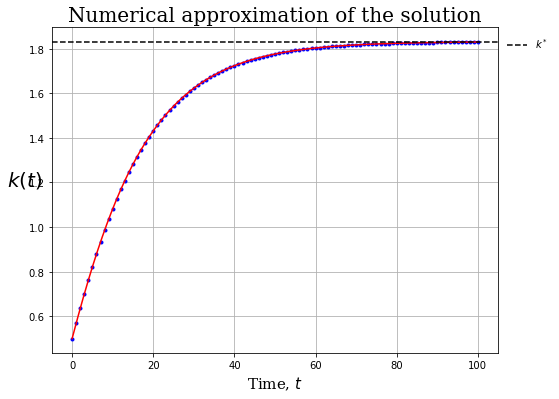

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# compute and plot the numeric approximation
t0, k0 = 0.0, 0.5
numeric_soln = cobb_douglas_model.ivp.solve(t0, k0, T=100, integrator='lsoda')
ax.plot(numeric_soln[:,0], numeric_soln[:,1], 'bo', markersize=3.0)

# compute and plot the analytic solution
ti = np.linspace(0, 100, 1000)
analytic_soln = solowpy.CobbDouglasModel.analytic_solution(cobb_douglas_model, ti, k0)
ax.plot(ti, analytic_soln[:,1], 'r-')

# equilibrium value of capital stock (per unit effective labor)
k_star = cobb_douglas_model.steady_state
ax.axhline(k_star, linestyle='dashed', color='k', label='$k^*$')

# axes, labels, title, etc
ax.set_xlabel('Time, $t$', fontsize=15, family='serif')
ax.set_ylabel('$k(t)$', rotation='horizontal', fontsize=20, family='serif')
ax.set_title('Numerical approximation of the solution',
             fontsize=20, family='serif')
ax.legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
ax.grid('on')

plt.show()

In [31]:
ti = np.linspace(0, 100, 1000)
interpolated_soln = cobb_douglas_model.ivp.interpolate(numeric_soln, ti, k=3)

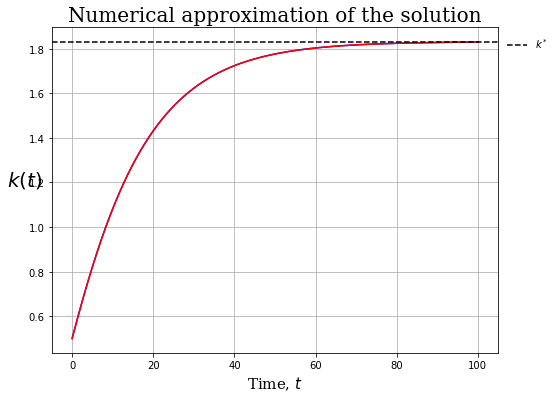

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# compute and plot the numeric approximation
ti = np.linspace(0, 100, 1000)
interpolated_soln = cobb_douglas_model.ivp.interpolate(numeric_soln, ti, k=3)
ax.plot(ti, interpolated_soln[:,1], 'b-')

# compute and plot the analytic solution
analytic_soln = solowpy.CobbDouglasModel.analytic_solution(cobb_douglas_model, ti, k0)
ax.plot(ti, analytic_soln[:,1], 'r-')

# equilibrium value of capital stock (per unit effective labor)
k_star = cobb_douglas_model.steady_state
ax.axhline(k_star, linestyle='dashed', color='k', label='$k^*$')

# axes, labels, title, etc
ax.set_xlabel('Time, $t$', fontsize=15, family='serif')
ax.set_ylabel('$k(t)$', rotation='horizontal', fontsize=20, family='serif')
ax.set_title('Numerical approximation of the solution',
             fontsize=20, family='serif')
ax.legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
ax.grid('on')

plt.show()

In [38]:
ti = np.linspace(0, 100, 1000)
residual = cobb_douglas_model.ivp.compute_residual(numeric_soln, ti, k=3)

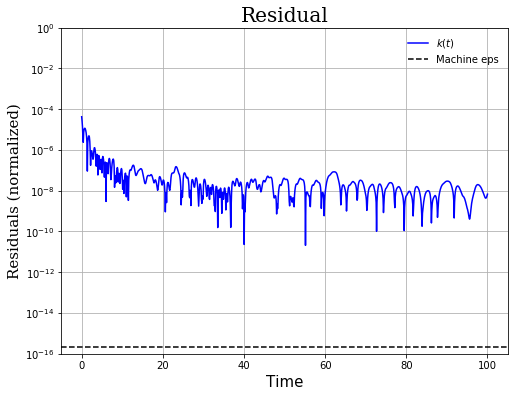

In [39]:
# extract the raw residuals
capital_residual = residual[:, 1]

# typically, normalize residual by the level of the variable
norm_capital_residual = np.abs(capital_residual) / interpolated_soln[:,1]

# create the plot
fig = plt.figure(figsize=(8, 6))
plt.plot(ti, norm_capital_residual, 'b-', label='$k(t)$')
plt.axhline(np.finfo('float').eps, linestyle='dashed', color='k', label='Machine eps')
plt.xlabel('Time', fontsize=15)
plt.ylim(1e-16, 1)
plt.ylabel('Residuals (normalized)', fontsize=15, family='serif')
plt.yscale('log')
plt.title('Residual', fontsize=20, family='serif')
plt.grid()
plt.legend(loc=0, frameon=False, bbox_to_anchor=(1.0,1.0))
plt.show()